In [5]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


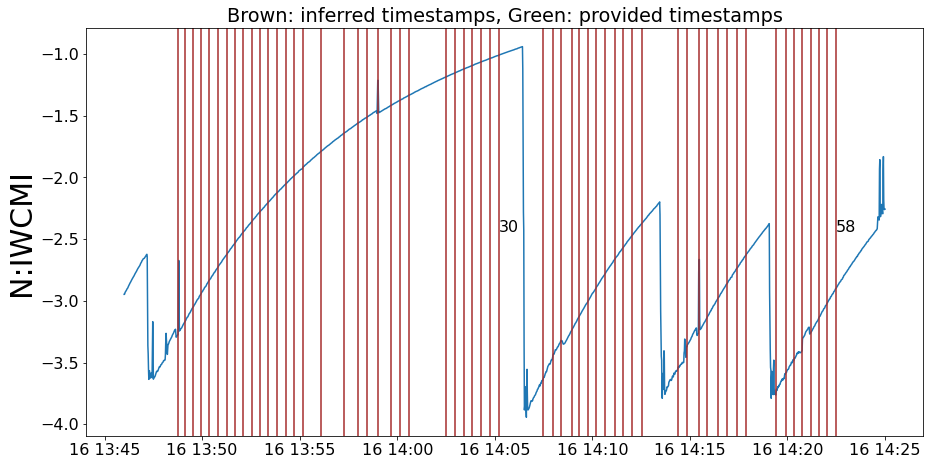

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:146: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)
/home/ilobach/fur/env/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv',
    show_plot=True
)
acnted_df_ROUND = shift.get_acnet_data_df('all_acnet_data_ROUND_case_03_16_2020.csv')
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_ROUND_Low_RF = shift.get_acnet_data_df('all_acnet_data_ROUND_low_RF_case_03_16_2020.csv')

In [7]:
rdt = res_df_ROUND['real_datetime']
time_intervals = [(rdt[0], rdt[30]), (rdt[31], rdt[42]), (rdt[43], rdt[50]), (rdt[51], rdt[58])]
def in_time_intervals(row):
    t = row.name
    return True in [(t>ti[0] and t<ti[1]) for ti in time_intervals]
time_intervals

[(Timestamp('2020-03-16 13:48:45'), Timestamp('2020-03-16 14:05:13')),
 (Timestamp('2020-03-16 14:07:27'), Timestamp('2020-03-16 14:12:34')),
 (Timestamp('2020-03-16 14:14:23'), Timestamp('2020-03-16 14:17:51')),
 (Timestamp('2020-03-16 14:19:26'), Timestamp('2020-03-16 14:22:28'))]

### removing two outliers in ROUND data:

In [8]:
outliers_ROUND = ['RefCurve_2020-03-16_61_135841.Wfm.bin', 'RefCurve_2020-03-16_86_141506.Wfm.bin']
res_df_ROUND = res_df_ROUND[~res_df_ROUND['waveform_file'].isin(outliers_ROUND)]

In [9]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")

# Loosses in the long cable cna be accounted for here by a factor `losses`

In [10]:
losses = 1.0
sum_channel_to_photoelectrons =\
    1/losses*get_from_config('sum_channel_to_photoelectrons')
new_meas_photons_per_electron =\
    1/losses*get_from_config("Measured_photons_per_electron")
new_meas_photons_per_electron

0.008820875499988542

In [11]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [12]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']
def var_theor(x, M):
    return x+1/M*x**2

In [13]:
for fluctuations_df in [res_df_FLAT, res_df_ROUND, res_df_ROUND_Low_RF]:
    N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
    varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
    fluctuations_df['N'] = N
    fluctuations_df['varN'] = varN
    fluctuations_df['varN_theor'] = fluctuations_df.apply(lambda row: var_theor(row['N'],Mfunc(row['Sigma_um_X'], row['Sigma_um_Y'], row['N:IWCMBE'])),axis=1) 

In [14]:
# plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
# plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
# plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
# x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
# plt.xlabel("Sum channel amplitude, V")
# plt.ylabel("Variance of the difference channel amplitude, V$^2$")
# plt.title(r"Shift 03-16-2020")
# plt.legend()
# plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
# plt.show()

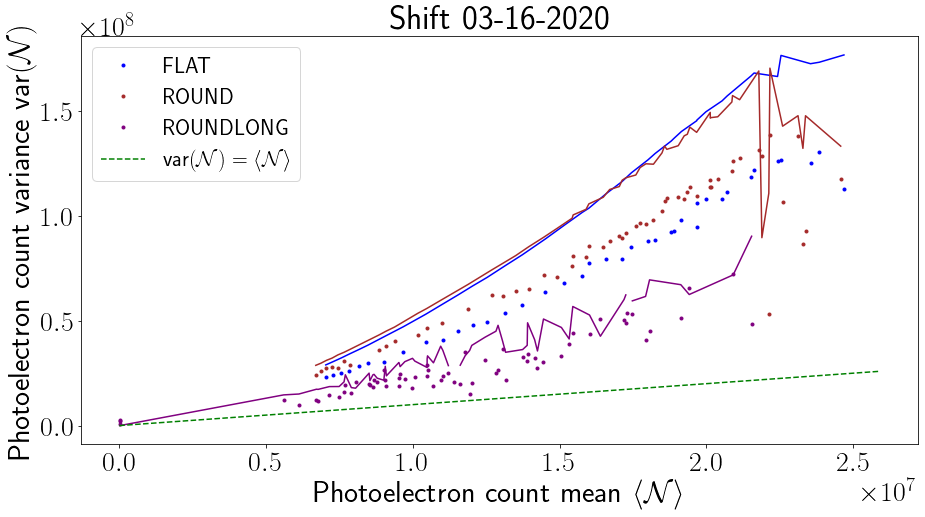

In [15]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'FLAT': res_df_FLAT, 'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

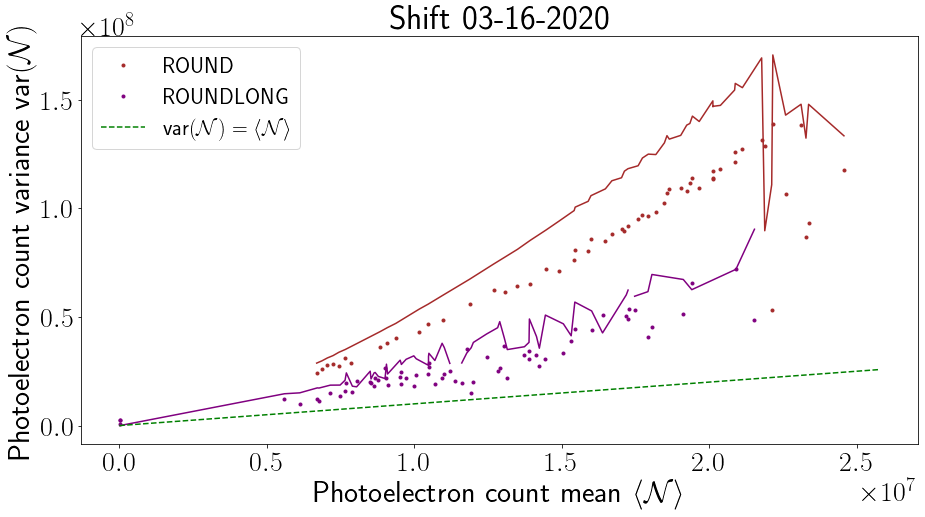

In [16]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

In [17]:
# acnet_df_ROUND_with_bunch_sizes = get_acnet_df_with_bunch_sizes(
#     shift,
#     "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
#     acnted_df_ROUND
# )

In [18]:
# acnet_df_ROUND_with_bunch_sizes.to_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'))

In [19]:
acnet_df_ROUND_with_bunch_sizes = pd.read_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_case_03_16_2020.csv'), index_col=0, parse_dates=True)
acnet_df_ROUND_with_bunch_sizes_in_time_intervals = acnet_df_ROUND_with_bunch_sizes[acnet_df_ROUND_with_bunch_sizes.apply(in_time_intervals, axis=1).values]

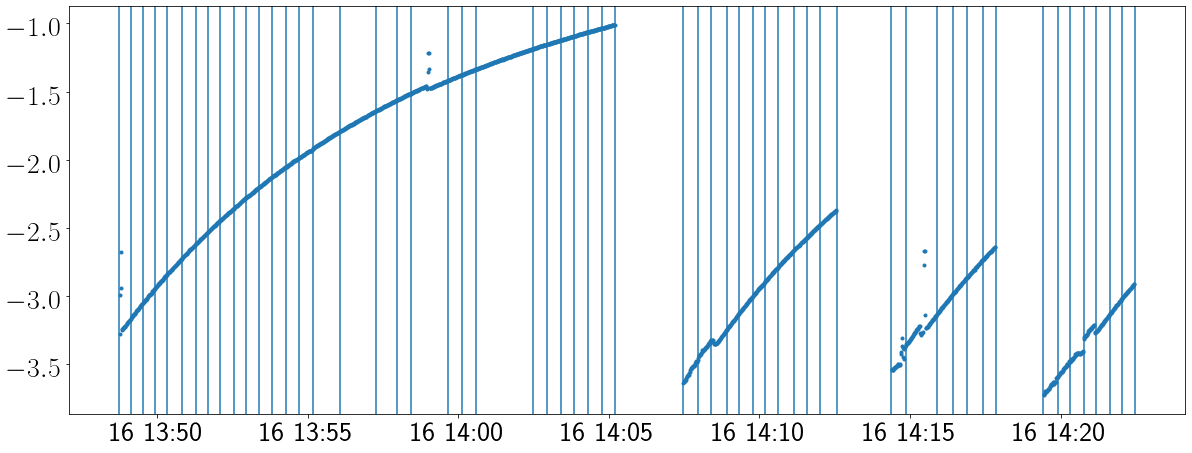

In [16]:
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

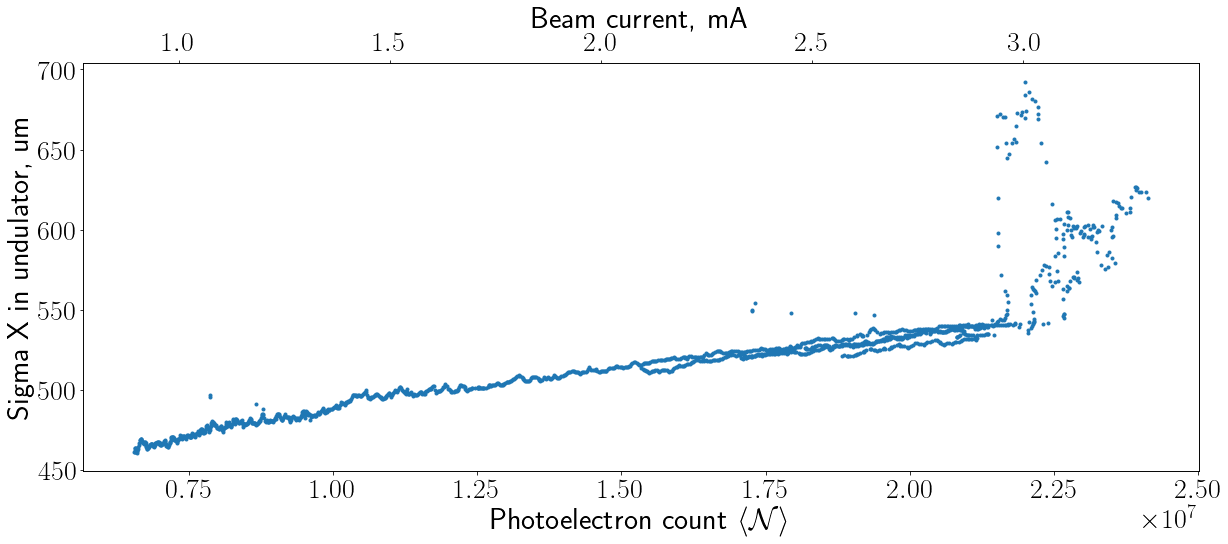

In [17]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

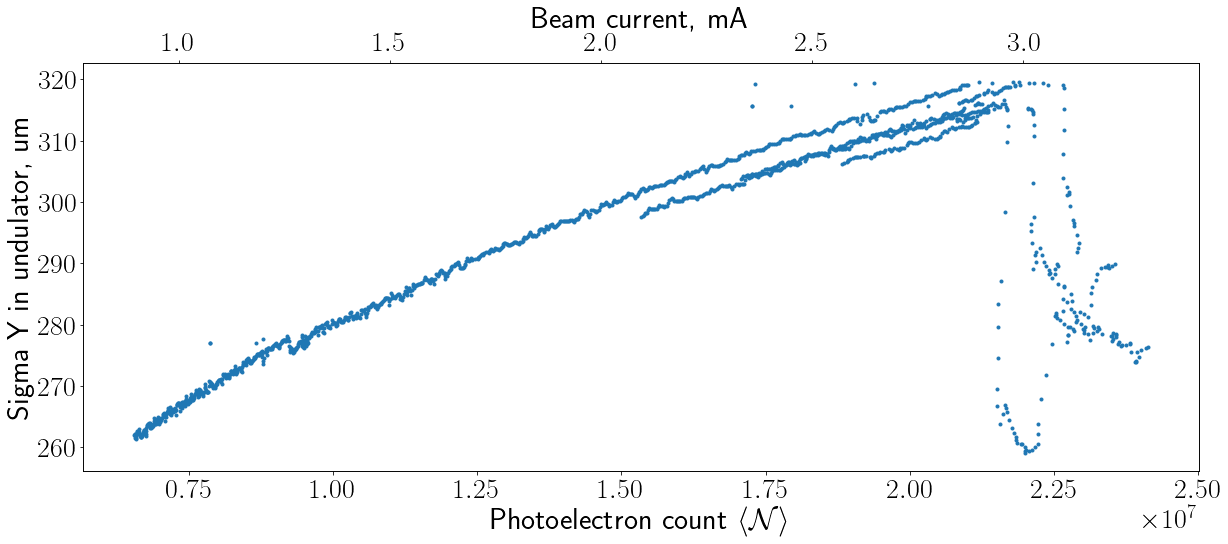

In [18]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

# Leaving only first injection:

In [19]:
first_injection = acnet_df_ROUND_with_bunch_sizes_in_time_intervals[acnet_df_ROUND_with_bunch_sizes_in_time_intervals.index<time_intervals[0][1]]
df = first_injection


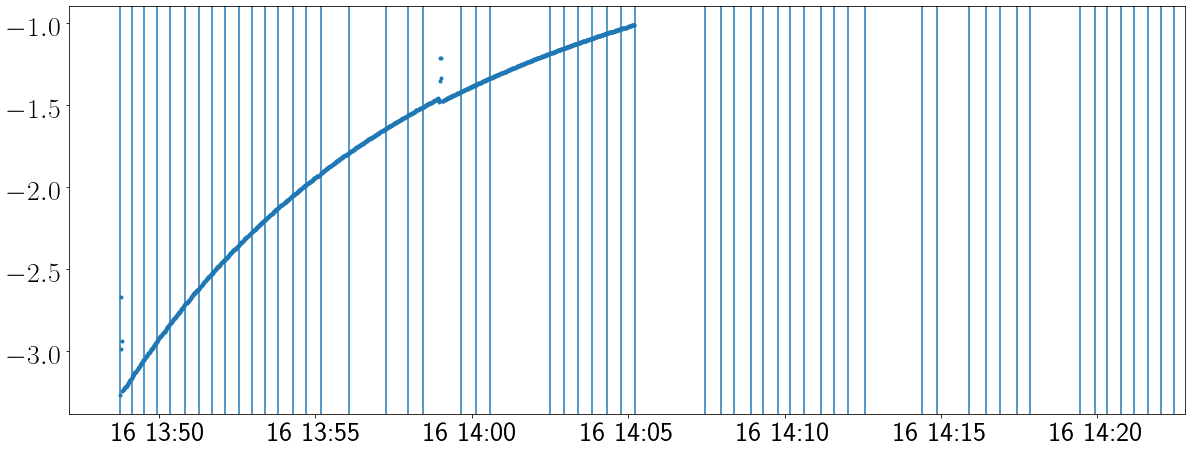

In [20]:
df = first_injection
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND['real_datetime']:
    ax.axvline(t)
plt.show()

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


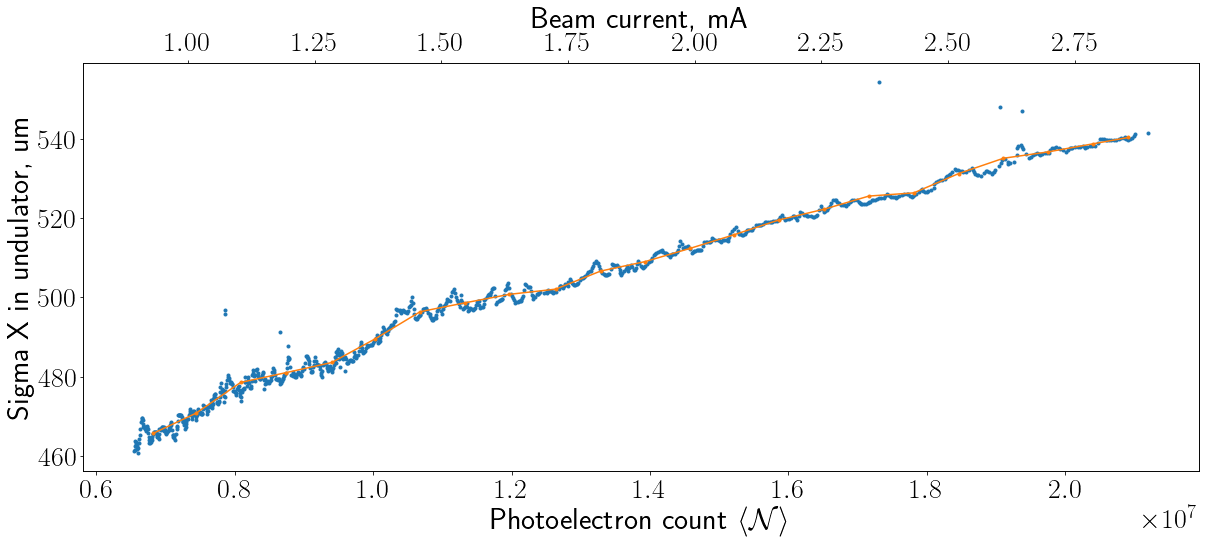

In [21]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save = pd.DataFrame(
    {"N": -df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
     "Sigma_um_X": df['Sigma_um_X']
    })
sx_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_X'], bounds_error=False, fill_value="extrapolate")
sx_interp = sx_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sx_err_stat = np.std(first_injection['Sigma_um_X'].values-sx_interp)
ax.plot(photoel, df['Sigma_um_X'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [22]:
sx_err_stat

2.02370910686093

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


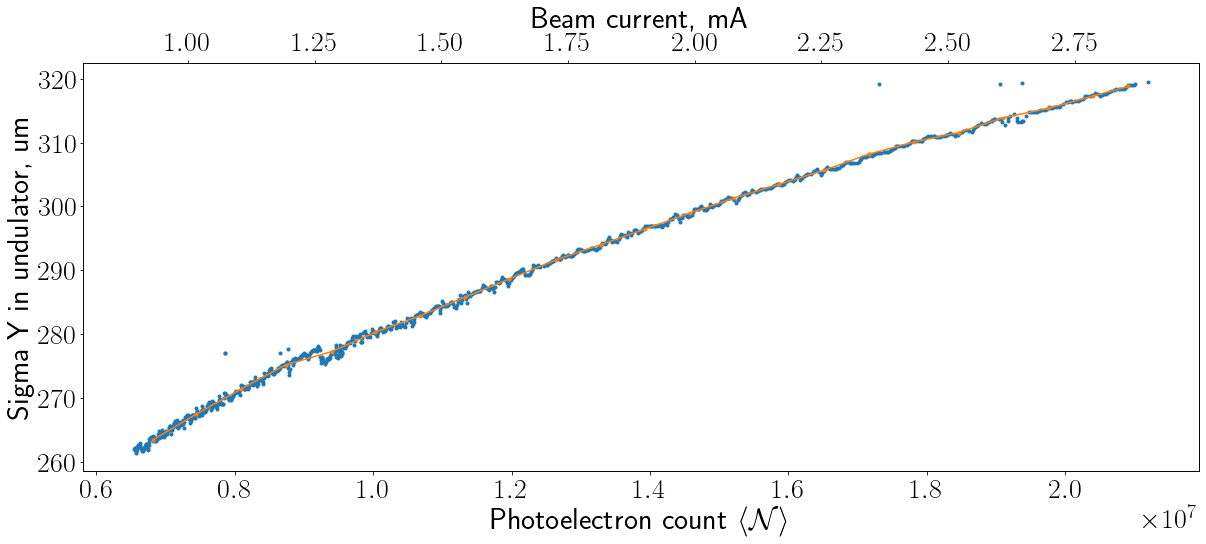

In [23]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save["Sigma_um_Y"] = df['Sigma_um_Y']
sy_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_Y'], bounds_error=False, fill_value="extrapolate")
sy_interp = sy_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sy_err_stat = np.std(first_injection['Sigma_um_Y'].values-sy_interp)
ax.plot(photoel, df['Sigma_um_Y'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [24]:
sy_err_stat

0.6831758341120098

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


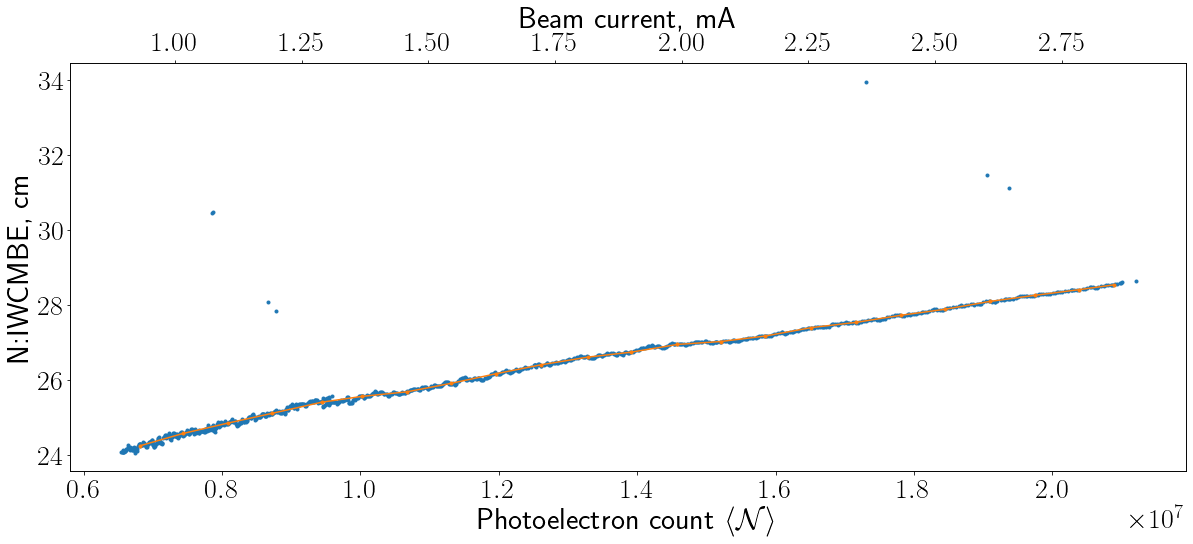

In [25]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBE'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['sz_um'] = 1e4*df['N:IWCMBE'] 
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBE'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBE'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBE'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBE, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [26]:
sz_err_stat

0.09119185892226393

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


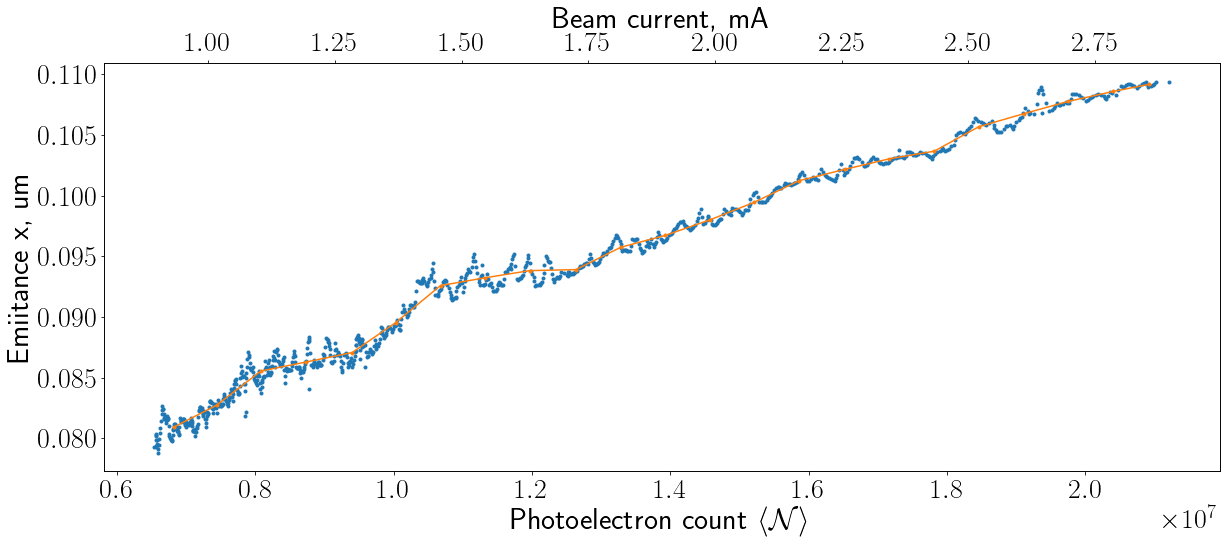

In [27]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ex_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance x, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ex_um'] = df['ex_um']
ex_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ex_um'], bounds_error=False, fill_value="extrapolate")
ex_interp = ex_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ex_err_stat = np.std(first_injection['ex_um'].values-ex_interp)
ax.plot(photoel, df['ex_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


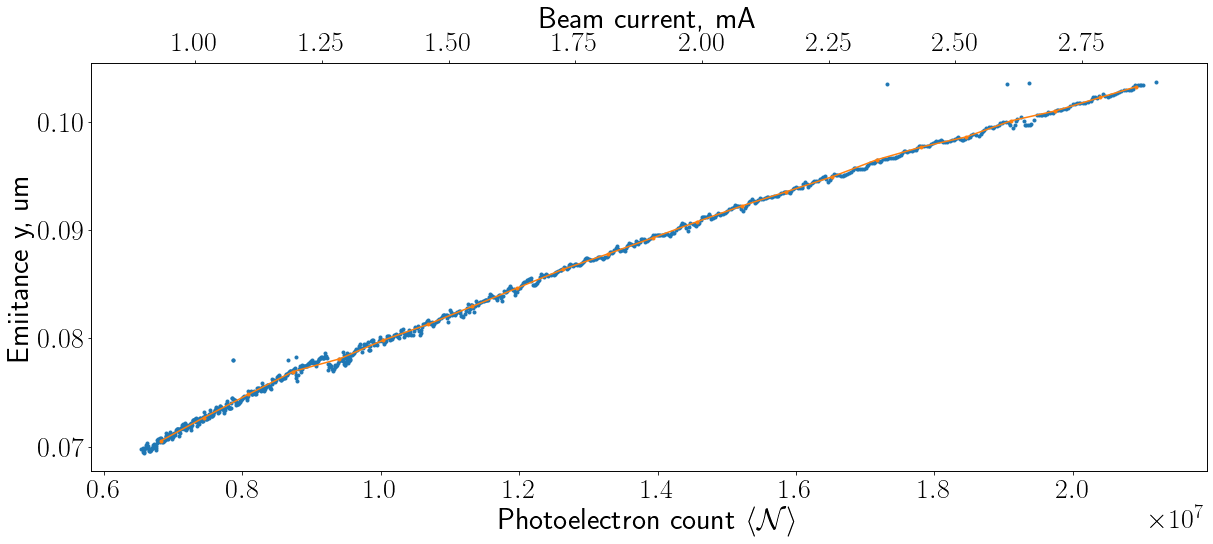

In [28]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ey_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance y, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ey_um'] = df['ey_um']
ey_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ey_um'], bounds_error=False, fill_value="extrapolate")
ey_interp = ey_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ey_err_stat = np.std(first_injection['ey_um'].values-ey_interp)
ax.plot(photoel, df['ey_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


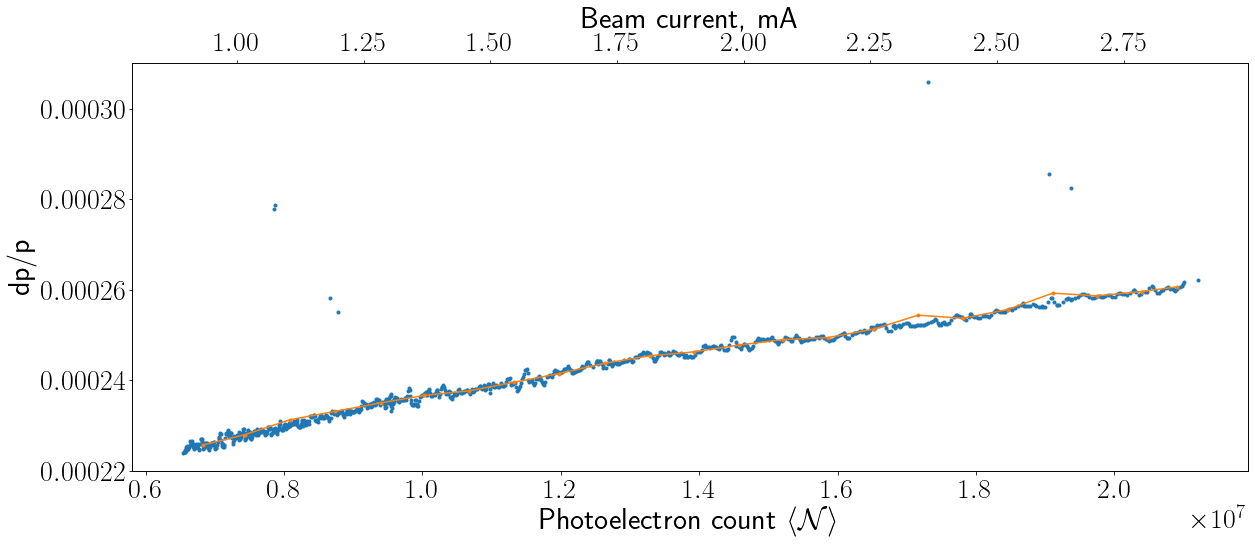

In [29]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['dp/p'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("dp/p")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['dp/p'] = df['dp/p']
dpp_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['dp/p'], bounds_error=False, fill_value="extrapolate")
dpp_interp = dpp_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
dpp_err_stat = np.std(first_injection['dp/p'].values-ey_interp)
ax.plot(photoel, df['dp/p'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [30]:
df_to_save = df_to_save.sort_values(by='N', ignore_index=True)
df_to_save

N  Sigma_um_X  Sigma_um_Y          sz_um     ex_um     ey_um  \
0   6.822991e+06  465.800456  263.442764  242511.737997  0.080929  0.070522   
1   7.442278e+06  470.868009  267.426168  245762.678713  0.082730  0.072671   
2   8.084032e+06  478.592273  271.339028  248504.548094  0.085552  0.074813   
3   8.735400e+06  481.047035  275.166796  251154.912227  0.086293  0.076938   
4   9.403211e+06  483.627377  277.247745  254092.589367  0.087076  0.078106   
5   1.002937e+07  489.576981  280.272400  255659.777833  0.089532  0.079819   
6   1.067964e+07  496.408777  282.855439  256853.526855  0.092593  0.081298   
7   1.132367e+07  498.631796  285.740379  259136.564602  0.093230  0.082964   
8   1.196957e+07  500.781086  288.636649  261665.115601  0.093824  0.084655   
9   1.263610e+07  502.086303  291.593880  264075.816348  0.093905  0.086398   
10  1.328790e+07  506.639963  294.006639  266109.165007  0.095754  0.087833   
11  1.392891e+07  509.015864  296.449522  267428.707311  0.096725  0.089299   
12  1.457567e+07  512.324227  298.945849  269478.414616  0.098011  0.090809   
13  1.521663e+07  515.787542  301.317027  270264.790317  0.099458  0.092255   
14  1.586307e+07  519.502552  303.465820  271728.519690  0.101237  0.093576   
15  1.652001e+07  522.223232  305.684828  273968.092319  0.102159  0.094949   
16  1.716548e+07  525.521573  308.203108  275365.422311  0.103032  0.096525   
17  1.781322e+07  526.320241  310.102005  277255.934062  0.103658  0.097713   
18  1.846028e+07  531.171583  311.574674  278840.269354  0.105680  0.098643   
19  1.910923e+07  535.037114  313.914065  280931.429940  0.106749  0.100133   
20  1.974959e+07  536.624844  315.353176  282580.417115  0.107760  0.101050   
21  2.039800e+07  538.651473  317.291372  284077.228085  0.108579  0.102296   
22  2.091223e+07  540.267132  318.802389  285360.622244  0.109159  0.103273   

        dp/p  
0   0.000226  
1   0.000228  
2   0.000231  
3   0.000233  
4   0.000235  
5   0.000237  
6   0.000238  
7   0.000240  
8   0.000241  
9   0.000244  
10  0.000245  
11  0.000246  
12  0.000248  
13  0.000249  
14  0.000249  
15  0.000251  
16  0.000254  
17  0.000254  
18  0.000256  
19  0.000259  
20  0.000259  
21  0.000260  
22  0.000261

In [33]:
df_to_save.to_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))